### Functions for cleaning + Feature selection + Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def load_transaction_data(trans_file_path):
    trans = pd.read_csv(trans_file_path, names=['sku', 'storeid', 'register', 'trannum', 'interID', 'saledate', 'stype', 'quantity',
                                                'orgprice', 'amt', 'seq', 'mic', 'unknown'])
    
    # Keep only purchases and positive amounts
    trans = trans[(trans['stype'] == 'P') & (trans['amt'] > 1) & (trans['orgprice'] > 1)]
    
    # Drop irrelevant columns
    trans = trans.drop(columns=['interID', 'stype', 'mic', 'unknown'])
    
    return trans

def load_sku_data(skst_file_path):
    skst = pd.read_csv(skst_file_path, names=['sku', 'storeid', 'cost', 'retail', 'unknown'])
    
    # Drop irrelevant columns
    skst = skst.drop(columns=['unknown'])
    
    # Get non-zero mean retail for each SKU
    mean_retail = skst.groupby('sku')['retail'].mean().replace(0, np.nan).fillna(0)
    
    return skst, mean_retail

def merge_dataframes(trans, skst, mean_retail):
    trans = pd.merge(trans, skst, on=['sku', 'storeid'], how='left')
    
    # Fill NaN values in 'retail' and 'orgprice' with appropriate values
    trans['retail'] = trans['retail'].fillna(trans['sku'].map(mean_retail)).fillna(trans['orgprice'])
    trans['orgprice'] = trans['orgprice'].fillna(trans['sku'].map(mean_retail))
    
    return trans

def feature_engineering(trans):
    trans['saledate'] = pd.to_datetime(trans['saledate'])
    trans['day_of_week'] = trans['saledate'].dt.dayofweek
    trans['month'] = trans['saledate'].dt.month
    trans['weekend'] = trans['day_of_week'].apply(lambda x: 1 if x >= 4 else 0)
    
    trans['amt'] = np.where(trans['amt'] == 0, trans['retail'], trans['amt'])
    trans['amt'] = np.where(trans['amt'] == 0, trans['orgprice'], trans['amt'])
    
    trans['percent_discount'] = np.maximum(0, (trans['orgprice'] - trans['amt']) / trans['orgprice'])
    trans.loc[trans['amt'] >= trans['orgprice'], 'percent_discount'] = 0
    trans.loc[trans['orgprice'] <= 0, 'percent_discount'] = 0
    trans.loc[trans['percent_discount'] < 0, 'percent_discount'] = 0
    
    trans['final_sale'] = np.where(trans['percent_discount'] > 0.5, 1, 0)
    trans['dollar_discount'] = trans['orgprice'] - trans['amt']
    trans['orig_profit'] = trans['amt'] - trans['cost']
    
    return trans

def join_dataframes(input_df, csv_file_path, columns, join_key='sku', how='inner'):
    columns += [join_key]
    csv_df = pd.read_csv(csv_file_path)
    csv_df.columns = ['sku', 'deptid', 'classid', 'upc', 'style', 'color', 'size', 'packsize', 'vendor', 'brand']
    
    joined_df = pd.merge(input_df, csv_df[columns], on=join_key, how=how)
    
    return joined_df

def get_high_value_df(joined_df, n=50):
    sku_sum_revenue = joined_df.groupby('sku')['amt'].sum()
    sorted_skus = sku_sum_revenue.sort_values(ascending=False).reset_index()
    sorted_skus['cumulative_sum'] = sorted_skus['amt'].cumsum()
    
    max_revenue = sorted_skus['cumulative_sum'].max() / (100 / n)
    high_value_skus = sorted_skus[sorted_skus.cumulative_sum < max_revenue]
    high_value_df = joined_df[joined_df['sku'].isin(high_value_skus['sku'])]
    
    return high_value_df

def filter_min_average_discount(high_value_df, percentage_column='percent_discount', min_average_discount=0.03):
    average_discount = high_value_df.groupby('sku')[percentage_column].mean().reset_index(name='avg_discount')
    filtered_df = average_discount[average_discount['avg_discount'] >= min_average_discount]
    merged_df = pd.merge(high_value_df, filtered_df, on='sku', how='inner')
    
    return merged_df

### Pipeline to execute all Functions

In [2]:
def process_data(trans_file_path, skst_file_path, clean_sku_file_path):
    trans = load_transaction_data(trans_file_path)
    skst, mean_retail = load_sku_data(skst_file_path)
    trans = merge_dataframes(trans, skst, mean_retail)
    trans = feature_engineering(trans)
    
    columns = ['brand', 'classid']
    joined_df = join_dataframes(trans, clean_sku_file_path, columns)
    
    high_value_df = get_high_value_df(joined_df)
    
    filtered_df = filter_min_average_discount(high_value_df)
    
    return filtered_df

In [3]:
def process_basket_data(filtered_df, num_baskets, filter_single_baskets = False):

    baskets = filtered_df.copy()
    baskets['sku'] = baskets['sku'].astype(str)
    
    baskets = baskets.groupby(['saledate', 'storeid', 'register', 'trannum'])['sku'].agg(['count', 'nunique', list]).reset_index()
    baskets.columns = ['saledate', 'storeid', 'register', 'trannum', 'TotalItems', 'UniqueItems', 'Items']
    
    total_num_baskets = len(baskets)
    
    if(filter_single_baskets):
        baskets = baskets[(baskets['Items'].apply(len) > 1) & (baskets['UniqueItems'] > 1)]
    
    filtered_num_baskets = len(baskets)
    baskets = baskets.sample(frac=1).head(num_baskets)
    
    return baskets, total_num_baskets, filtered_num_baskets

In [4]:
import pandas as pd

def preprocess_basket_data(baskets_df, *groupby_columns):
    """
    Preprocesses basket data by converting it to a binary representation.
    Returns:
    - basket_encoded: DataFrame, the preprocessed binary representation
    """
    basket_encoded = (
        baskets_df.set_index(list(groupby_columns))['Items']
        .apply(lambda x: list(set(x)))
        .apply(pd.Series)
        .stack()
        .reset_index()
        .groupby(list(groupby_columns) + [0])
        .size()
        .unstack()
        .reset_index()
        .fillna(0)
        .set_index(list(groupby_columns))
    )
    return basket_encoded

In [5]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

def run_apriori(data, min_support, min_confidence):
    """
    Run the Apriori algorithm on the provided DataFrame and return relevant results.
    """
    # Convert the binary representation to boolean for Apriori algorithm
    basket_sets = data.astype(bool)

    # Use Apriori algorithm to find frequent itemsets
    frequent_itemsets = apriori(basket_sets, min_support=min_support, use_colnames=True)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    return frequent_itemsets, rules

# Execute Pipeline

### Option 1: Execute all:

In [6]:

# 01. Read Data and Filter trans Data
directory = 'Dillards POS/'
skst_file_path = directory + 'skstinfo.csv'
trans_file_path = directory + 'trans_final.csv'
clean_sku_file_path = directory + 'sku_final.csv'
# 02. process_data
trans_final = process_data(trans_file_path, skst_file_path, clean_sku_file_path)
print(f'trans_final shape: {trans_final.shape}')
print(f'Amount in Transaction Selection: {trans_final["amt"].sum()}')

# 03. Process_basket_data
filter_single_baskets = True
num_baskets = 100000
baskets_final,total_num_baskets, filtered_num_baskets = process_basket_data(trans_final, num_baskets, filter_single_baskets)

print(f'total num of baskets: {total_num_baskets}')
print(f'filtered num of baskets: {filtered_num_baskets}')
print(f'final selection of baskets: {baskets_final.shape}')

# 04. Preprocess_basket_data
groupby_columns = ['saledate', 'storeid', 'register', 'trannum']
basket_encoded = preprocess_basket_data(baskets_final, *groupby_columns)

# 05. Run_apriori
min_support_threshold = 0.001
min_confidence_threshold = 0.5
frequent_itemsets, rules = run_apriori(basket_encoded, min_support_threshold, min_confidence_threshold)

print("executed! Let's Go!")


trans_final shape: (23900020, 21)
Amount in Transaction Selection: 699341754.8000008
total num of baskets: 15128823
filtered num of baskets: 3520231
final selection of baskets: (100000, 7)
executed! Let's Go!


### Option 2: Execute only Model:

In [ ]:
# 03. Process_basket_data
filter_single_baskets = True
num_baskets = 200000
baskets_final,total_num_baskets, filtered_num_baskets = process_basket_data(trans_final, num_baskets, filter_single_baskets)

print(f'total num of baskets: {total_num_baskets}')
print(f'filtered num of baskets: {filtered_num_baskets}')
print(f'final selection of baskets: {baskets_final.shape}')

# 04. Preprocess_basket_data
groupby_columns = ['saledate', 'storeid', 'register', 'trannum']
basket_encoded = preprocess_basket_data(baskets_final, *groupby_columns)

# 05. Run_apriori
min_support_threshold = 0.001
min_confidence_threshold = 0.5
frequent_itemsets, rules = run_apriori(basket_encoded, min_support_threshold, min_confidence_threshold)

print("executed! Let's Go!")

total num of baskets: 15128823
filtered num of baskets: 3520231
final selection of baskets: (200000, 7)


### Explore Rules

In [8]:
rules.sort_values('confidence', ascending = False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
39,"(6490353, 6480353)",(6470353),0.00114,0.00218,0.00101,0.885965,406.405923,0.001008,8.750114,0.998678
43,"(6642521, 6742521)",(6752521),0.00141,0.00205,0.00121,0.858156,418.612697,0.001207,7.035547,0.999020
34,"(6062521, 6032521)",(6072521),0.00134,0.00203,0.00114,0.850746,419.086832,0.001137,6.686399,0.998952
33,"(6072521, 6032521)",(6062521),0.00137,0.00202,0.00114,0.832117,411.939004,0.001137,5.944490,0.998941
16,(6480353),(6470353),0.00158,0.00218,0.00131,0.829114,380.327488,0.001307,5.839095,0.998949


In [9]:
rules.sort_values('support', ascending = False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
26,(7596135),(6656135),0.00417,0.00748,0.00251,0.601918,80.470383,0.002479,2.493258,0.991708
28,(6752521),(6742521),0.00205,0.00204,0.00162,0.790244,387.374462,0.001616,4.757716,0.999467
29,(6742521),(6752521),0.00204,0.00205,0.00162,0.794118,387.374462,0.001616,4.847186,0.999457
11,(6072521),(6062521),0.00203,0.00202,0.00149,0.733990,363.361459,0.001486,3.751666,0.999276
12,(6062521),(6072521),0.00202,0.00203,0.00149,0.737624,363.361459,0.001486,3.803584,0.999266


In [14]:
rules.shape

(48, 10)

In [15]:
rules.sort_values('support', ascending = False).head(40)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
26,(7596135),(6656135),0.00417,0.00748,0.00251,0.601918,80.470383,0.002479,2.493258,0.991708
28,(6752521),(6742521),0.00205,0.00204,0.00162,0.790244,387.374462,0.001616,4.757716,0.999467
29,(6742521),(6752521),0.00204,0.00205,0.00162,0.794118,387.374462,0.001616,4.847186,0.999457
11,(6072521),(6062521),0.00203,0.00202,0.00149,0.733990,363.361459,0.001486,3.751666,0.999276
12,(6062521),(6072521),0.00202,0.00203,0.00149,0.737624,363.361459,0.001486,3.803584,0.999266
18,(6470353),(6490353),0.00218,0.00210,0.00148,0.678899,323.285277,0.001475,3.107746,0.999085
17,(6490353),(6470353),0.00210,0.00218,0.00148,0.704762,323.285277,0.001475,3.379713,0.999005
23,(6642521),(6752521),0.00184,0.00205,0.00146,0.793478,387.062566,0.001456,4.832179,0.999255
24,(6752521),(6642521),0.00205,0.00184,0.00146,0.712195,387.062566,0.001456,3.468183,0.999465
21,(6642521),(6742521),0.00184,0.00204,0.00141,0.766304,375.639386,0.001406,4.270340,0.999176


### Check if Rules seem plausible

In [ ]:
frequent_itemsets.tail()

In [ ]:
basket_encoded[basket_encoded['6440353'] == 1]['6460353'].head()

In [ ]:

sku_1 = 6276633
sku_2 = 6756633

# Create a column indicating whether each row contains the specified SKUs
trans_final['has_sku_1'] = (trans_final['sku'] == sku_1)
trans_final['has_sku_2'] = (trans_final['sku'] == sku_2)

# Group by basket identifiers and count occurrences
counts = trans_final.groupby(['saledate', 'storeid', 'register', 'trannum'])[['has_sku_1', 'has_sku_2']].any().reset_index()

# Count occurrences of each SKU and both SKUs across all baskets
sku_1_count = counts['has_sku_1'].sum()
sku_2_count = counts['has_sku_2'].sum()
both_skus_count = (counts['has_sku_1'] & counts['has_sku_2']).sum()

# Print the counts
print(f"Count for SKU {sku_1}: {sku_1_count}")
print(f"Count for SKU {sku_2}: {sku_2_count}")
print(f"Count for both SKUs: {both_skus_count}")


# Visualization for Presentation:

### a) Discount vs Profit

In [ ]:

# 01. Read Data and Filter trans Data
directory = 'Dillards POS/'
skst_file_path = directory + 'skstinfo.csv'
trans_file_path = directory + 'trans_final.csv'
clean_sku_file_path = directory + 'sku_final.csv'
# 02. process_data
trans_final = process_data(trans_file_path, skst_file_path, clean_sku_file_path)
print(f'trans_final shape: {trans_final.shape}')
print(f'Amount in Transaction Selection: {trans_final["amt"].sum()}')

In [ ]:
trans_final.head()

In [ ]:
import matplotlib.pyplot as plt
# Step 3: Group by "saledate" and calculate the averages
grouped_df = trans_final.groupby('saledate')[['orgprice', 'amt', 'cost']].sum().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for col in ['orgprice', 'amt', 'cost']:
    plt.plot(grouped_df['saledate'], grouped_df[col], label=f'Average {col}')

plt.xlabel('Sales Date')
plt.ylabel('$ Value')
plt.title('Sum of Original Price, Amount and Cost Over Time')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Step 3: Group by "saledate" and calculate the averages
grouped_df = trans_final.groupby('saledate')[['dollar_discount', 'orig_profit']].sum().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for col in ['dollar_discount', 'orig_profit']:
    plt.plot(grouped_df['saledate'], grouped_df[col], label=f'Sum {col}')

plt.xlabel('Sales Date')
plt.ylabel('Sum Discount & Sum Oiginal Profit')
plt.title('Sum of Profit vs Discount Over Time')
plt.legend()
plt.show()

In [ ]:
grouped_df.head()

In [ ]:
grouped_df['dollar_discount'].corr(grouped_df['orig_profit'])

## b) SKU Discount over time

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Get the first 5 unique values of the "sku" column
#top_skus = trans_final.groupby('sku')['amt'].sum().sortvalues(ascending=False)[0:5]
top_skus = trans_final.groupby('sku')['amt'].sum().sort_values(ascending=False).reset_index().head(3).iloc[:,0]

# Step 2: Filter the DataFrame based on the first 5 unique values of "sku"
analysis1 = trans_final[trans_final['sku'].isin(top_skus)]
print(analysis1.shape)

# Step 3: Group by "sku" and "sales date", calculate the average of "discount"
analysis1 = analysis1.groupby(['sku', 'saledate'])['percent_discount'].mean().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for sku in top_skus:
    sku_data = analysis1[analysis1['sku'] == sku]
    plt.plot(sku_data['saledate'], sku_data['percent_discount'], label=f'SKU {sku}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for Top 3 SKUs')
plt.legend()
plt.show()

In [ ]:
top_skus

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "660826"
analysis2 = trans_final[trans_final['sku'] == 660826]

# Step 1: Get the first 5 unique values of the "storeid" column
top_stores = analysis2.groupby('storeid')['amt'].sum().sort_values(ascending=False).reset_index().head(3).iloc[:,0]
print(top_stores)

# Step 2: Filter the DataFrame based on the first 5 unique values of "sku"
analysis2 = trans_final[trans_final['storeid'].isin(top_stores)]
print(analysis2.shape)

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
analysis2 = analysis2.groupby(['storeid', 'saledate'])['percent_discount'].mean().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in analysis2['storeid'].unique():
    store_data = analysis2[analysis2['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['percent_discount'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for SKU 660826 in Different Stores')
plt.legend()
plt.show()

## c) Two associated SKUs Discount Plot

(32836, 21)


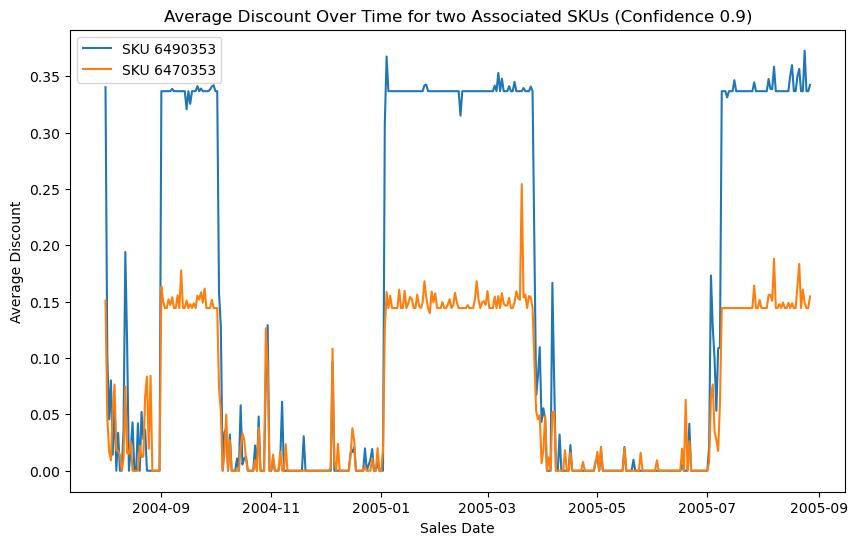

In [24]:
import matplotlib.pyplot as plt

# Step 1: Select Market Basket SKUs
# 6340353, 6320353
# 6642521, 6742521
# New: 6656135
# 6642521 --> 6752521, 6742521
# Gut aber ASS? selected_skus = [6490353,6072521]
# selected_skus = [6642521, 6752521, 6742521]
# selected_skus = [6696135,6656135]

selected_skus = [6490353,6470353]

# Step 2: Filter the DataFrame based on the first 5 unique values of "sku"
analysis3 = trans_final[trans_final['sku'].isin(selected_skus)]
print(analysis3.shape)

# Step 3: Group by "sku" and "sales date", calculate the average of "discount"
analysis3 = analysis3.groupby(['sku', 'saledate'])['percent_discount'].mean().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for sku in selected_skus:
    sku_data = analysis3[analysis3['sku'] == sku]
    plt.plot(sku_data['saledate'], sku_data['percent_discount'], label=f'SKU {sku}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for two Associated SKUs (Confidence 0.9)')
plt.legend()
plt.show()

## Test the selected SKUs for suitability

In [19]:
analysis5 = trans_final[trans_final['sku'] == 6656135]

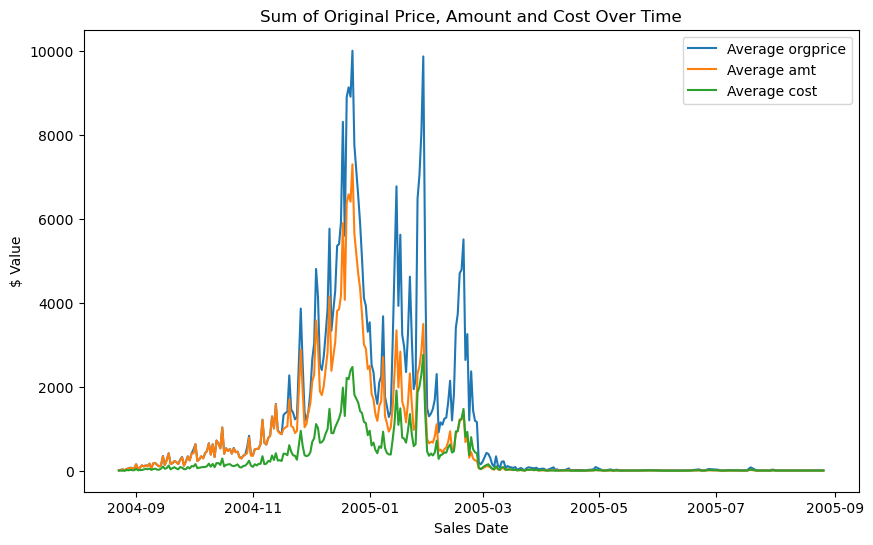

In [20]:
import matplotlib.pyplot as plt
# Step 3: Group by "saledate" and calculate the averages
grouped_df = analysis5.groupby('saledate')[['orgprice', 'amt', 'cost']].sum().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for col in ['orgprice', 'amt', 'cost']:
    plt.plot(grouped_df['saledate'], grouped_df[col], label=f'Average {col}')

plt.xlabel('Sales Date')
plt.ylabel('$ Value')
plt.title('Sum of Original Price, Amount and Cost Over Time')
plt.legend()
plt.show()

In [21]:
discounts = np.arange(0, 0.85, 0.05)
discounts

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ])